# Making a GAN to generate MNIST digits

## Boring imports and datasets

In [1]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sklearn.model_selection as ms
from tqdm import tqdm,trange
import albumentations as A
from torchvision import transforms
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [2]:
class Hyperparams:
    num_epochs = 10
    discriminator_lr = 2e-3
    generator_lr = 1e-3
    num_latent_features = 100

    
    normalise_transform = transforms.Compose([
        transforms.Normalize(mean=(0.5), std=(0.5))
        ])

In [3]:
class MNIST_Dataset(Dataset):
    def __init__(self, metadata_df, images, normalise_transform = Hyperparams.normalise_transform ):
        self.metadata_df = metadata_df
        self.images = images
        self.normalise_transform = normalise_transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self,idx):
        idx = int(idx)

        image = torch.tensor(images[idx]).unsqueeze(0)
        label = torch.tensor([1])

        if self.normalise_transform:
            image = self.normalise_transform(image.float())

        return image, label

In [4]:
metadata = pd.read_csv('data/MNIST/metadata.csv')
train_metadata, valid_metadata = ms.train_test_split(metadata, test_size=0.2, train_size=0.8, random_state=19, shuffle=True, stratify=metadata['labels'])

images = np.load('data/MNIST/images.npy') / 255

In [5]:
train_dataset = MNIST_Dataset(train_metadata.reset_index(), images[train_metadata.index])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)

valid_dataset = MNIST_Dataset(valid_metadata.reset_index(), images[valid_metadata.index])
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=256)

## Fun part: models

In [6]:
# I have no idea if this is the way to make the generator/discriminator but I'll do it in a encoder/decoder way since thats the intuition I have about it
# Now that I know more, I believe this is a DCGAN, original GAN flattens the images and thus uses only Linear layers, but I hate Computer Vision with flattened images

class Generator(nn.Module):
    def __init__(self,num_latent_features):
        super(Generator, self).__init__()

        self.first_linear = nn.Sequential(
            nn.Linear(num_latent_features,1024),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.ReLU(),
        
            nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.first_linear(x).view(-1,1024,1,1)
        x = self.decoder(x);
        return x

class Discriminator(nn.Module):
    def __init__(self,num_embeddings):
        super(Discriminator, self).__init__()
        self.num_embeddings = num_embeddings

        self.encoder = nn.Sequential(
            # 32x32 to 28x28
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            
            # 28x28 to 14x14
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        
            # 14x14 to 7x7
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
        
            # 7x7 to 3x3
            nn.Conv2d(256, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
        
            # 3x3 to 1x1
            nn.Conv2d(512, self.num_embeddings, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.1),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.num_embeddings, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
        )

    def forward(self, x):
        x = self.encoder(x).view(-1,self.num_embeddings)
        x = self.classifier(x)
        return x


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


## Train / Valid

In [7]:
def train(train_loader, generator, discriminator, device, g_optimizer, d_optimizer , d_criterion, g_criterion, distribution,epoch):
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    d_losses = []
    g_losses = []
        
    for index, batch in enumerate(tqdm(train_loader, total = len(train_loader))):

        #First Step -> Discriminator training
        discriminator.train()
        generator.eval()
        
        images, _ = batch
        real_images = images.to(device)
        latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
        with torch.no_grad():
            fake_images = generator(latent_samples)
            
        images = torch.cat([real_images,fake_images])
        
        ones = (torch.ones(real_images.shape[0]) - 0.1).to(device)
        zeros = (torch.zeros(real_images.shape[0]) + 0.1).to(device)
        labels = torch.cat([ones,zeros],0).unsqueeze(1).to(device)

        discriminator_outputs = discriminator(images)
        discriminator_preds = torch.sigmoid(discriminator_outputs)
        
        discriminator_loss = d_criterion(discriminator_outputs, labels)
        d_losses.append(discriminator_loss.item())
        d_optimizer.zero_grad()
        discriminator_loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
        d_optimizer.step()


        #Second Step -> Generator training
        discriminator.eval()
        generator.train()
        
        latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
        fake_images = generator(latent_samples)

        credibility = discriminator(fake_images)
        expected_credibility = torch.ones_like(credibility)
        generator_loss = g_criterion(credibility,expected_credibility)
        g_losses.append(generator_loss.item())
        g_optimizer.zero_grad()
        generator_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
        g_optimizer.step()
    
    mean_d_loss = np.mean(d_losses)
    mean_g_loss = np.mean(g_losses)
    print(f'Training Discriminator loss : {mean_d_loss} | Training Generator loss : {mean_g_loss}')

In [8]:
def validate(valid_loader, generator, discriminator, device, distribution, fixed_latent_vectors,epoch):
    discriminator.eval()
    generator.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)

    with torch.no_grad():
        for index, batch in enumerate(tqdm(valid_loader, total = len(valid_loader))):
    
            #First Step -> Validate Discriminator
            images, _ = batch
            real_images = images.to(device)
            latent_samples = distribution.sample((real_images.shape[0], Hyperparams.num_latent_features)).to(device)
            fake_images = generator(latent_samples)
            images = torch.cat([real_images,fake_images])
            
            ones, zeros = torch.ones(real_images.shape[0]), torch.zeros(fake_images.shape[0])
            labels = torch.cat([ones,zeros],0).unsqueeze(1).to(device)
            
            random_indices =  torch.randperm(images.shape[0])
            images = images[random_indices]
            labels = labels[random_indices]
    
            discriminator_outputs = discriminator(images)
            discriminator_preds = torch.sigmoid(discriminator_outputs)
            
            all_preds = torch.cat([all_preds,discriminator_preds], 0)
            all_labels = torch.cat([all_labels,labels], 0)
    
        
        accuracy = (((all_preds > 0.5) == all_labels).sum() / all_labels.shape[0]).item()
        print(f'Valid Discriminator accuracy : {accuracy}')
    
        #Second Step -> Validate Generator
        fixed_latent_vectors = fixed_latent_vectors.to(device)
        fake_images = generator(fixed_latent_vectors)
        credibility = torch.sigmoid(discriminator(fake_images))

        fake_images_np = fake_images.cpu().detach().numpy()
        credibility_np = credibility.cpu().detach().numpy()
        
        fig, axes = plt.subplots(5, 5, figsize=(7, 7))  # Change the subplot dimensions to 5x5
        
        # Assume fake_images_np is (25, latent_space) and credibility_np is (25,)
        for i in range(5):
            for j in range(5):
                ax = axes[i, j]
                img = fake_images_np[5 * i + j]
                score = credibility_np[5 * i + j]
                ax.imshow(img[0], cmap='gray')
                ax.set_title(f"Credibility: {score.item():.2f}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()


        return accuracy, fig

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(num_latent_features = Hyperparams.num_latent_features).to(device)
generator.apply(weights_init)
discriminator = Discriminator(num_embeddings = 1024).to(device)
discriminator.apply(weights_init)

distribution = torch.distributions.Normal(0, 10)
fixed_latent_vectors = distribution.sample((25, Hyperparams.num_latent_features))

d_criterion = nn.BCEWithLogitsLoss()
g_criterion = nn.BCEWithLogitsLoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=Hyperparams.discriminator_lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=Hyperparams.generator_lr, betas=(0.5, 0.999))

Epoch 1/10


100%|██████████| 438/438 [00:15<00:00, 28.71it/s]


Training Discriminator loss : 0.336270913617796 | Training Generator loss : 1.9647542014213142


100%|██████████| 55/55 [00:00<00:00, 57.53it/s]


Valid Discriminator accuracy : 1.0


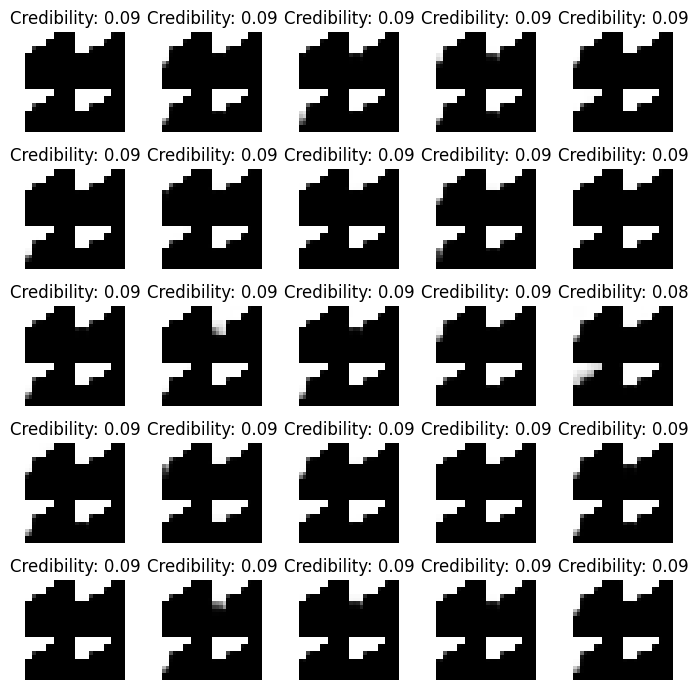

----------------------------------------------------------------------------------------------------
Epoch 2/10


100%|██████████| 438/438 [00:13<00:00, 31.63it/s]


Training Discriminator loss : 0.5420421476913914 | Training Generator loss : 2.012130947877147


100%|██████████| 55/55 [00:00<00:00, 58.83it/s]


Valid Discriminator accuracy : 0.9994999766349792


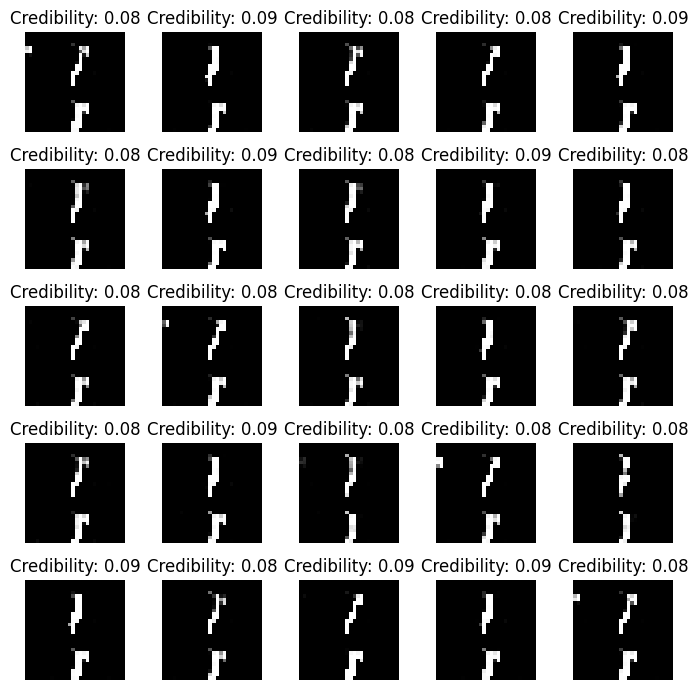

----------------------------------------------------------------------------------------------------
Epoch 3/10


100%|██████████| 438/438 [00:13<00:00, 31.92it/s]


Training Discriminator loss : 0.3610804924001432 | Training Generator loss : 2.6748888609020813


100%|██████████| 55/55 [00:00<00:00, 58.60it/s]


Valid Discriminator accuracy : 0.5


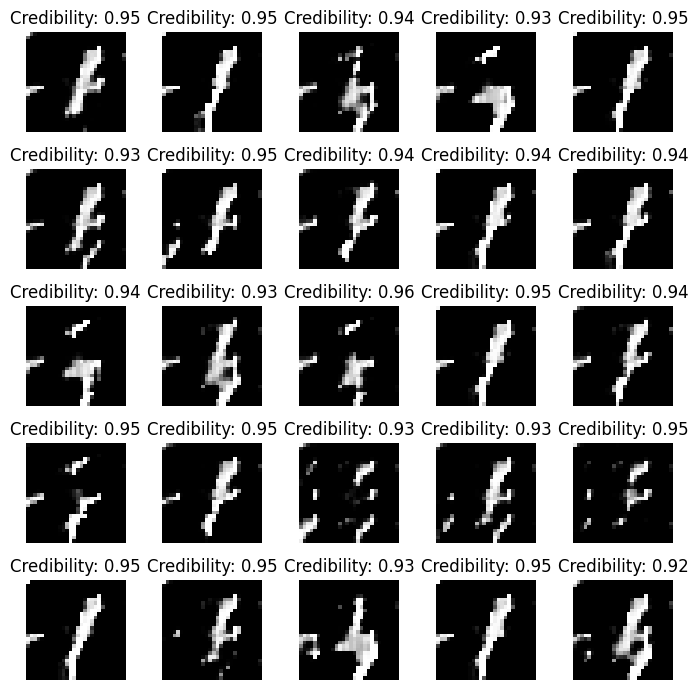

----------------------------------------------------------------------------------------------------
Epoch 4/10


100%|██████████| 438/438 [00:13<00:00, 31.90it/s]


Training Discriminator loss : 0.34175417153802634 | Training Generator loss : 2.377735558552795


100%|██████████| 55/55 [00:00<00:00, 58.69it/s]


Valid Discriminator accuracy : 0.8826428651809692


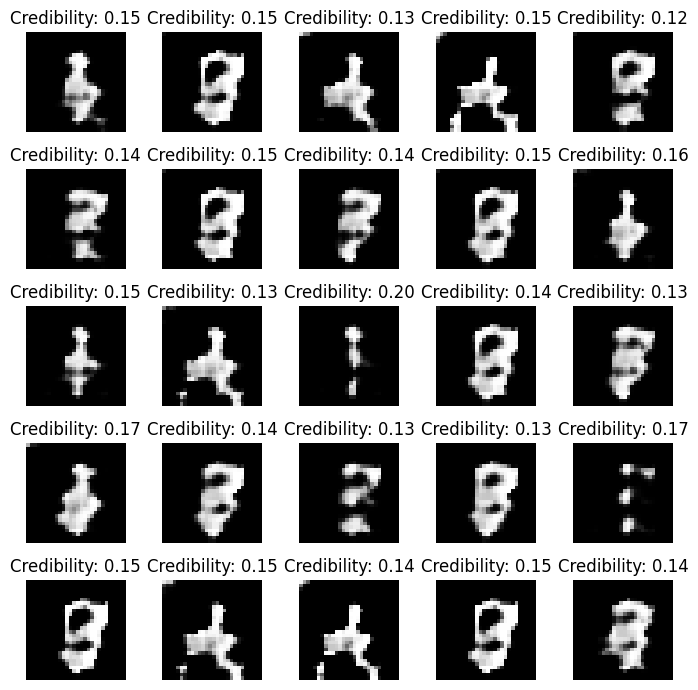

----------------------------------------------------------------------------------------------------
Epoch 5/10


100%|██████████| 438/438 [00:13<00:00, 31.78it/s]


Training Discriminator loss : 0.3511368233591454 | Training Generator loss : 1.9312105871711487


100%|██████████| 55/55 [00:00<00:00, 59.05it/s]


Valid Discriminator accuracy : 0.6781785488128662


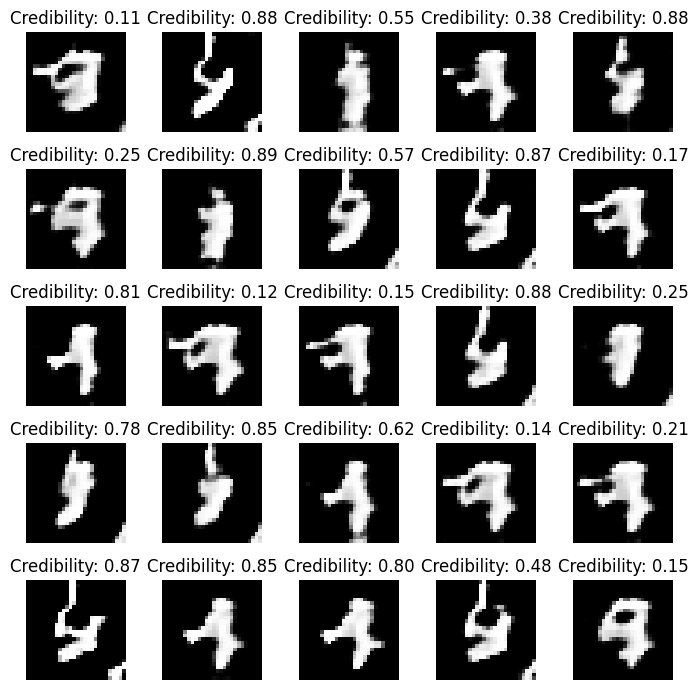

----------------------------------------------------------------------------------------------------
Epoch 6/10


100%|██████████| 438/438 [00:13<00:00, 31.82it/s]


Training Discriminator loss : 0.3538192552110376 | Training Generator loss : 1.872538831771764


100%|██████████| 55/55 [00:00<00:00, 59.02it/s]


Valid Discriminator accuracy : 0.5


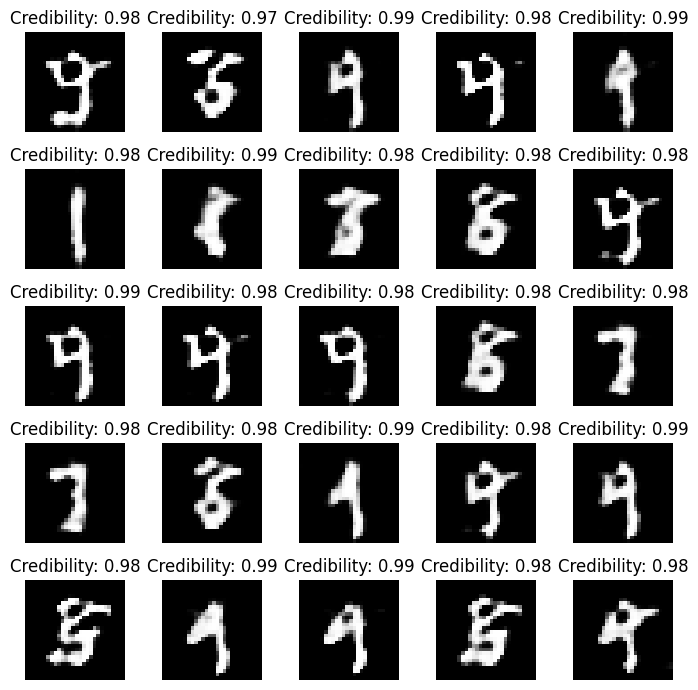

----------------------------------------------------------------------------------------------------
Epoch 7/10


100%|██████████| 438/438 [00:13<00:00, 31.74it/s]


Training Discriminator loss : 0.3443433590675598 | Training Generator loss : 1.6665834407651687


100%|██████████| 55/55 [00:00<00:00, 58.70it/s]


Valid Discriminator accuracy : 0.9686785340309143


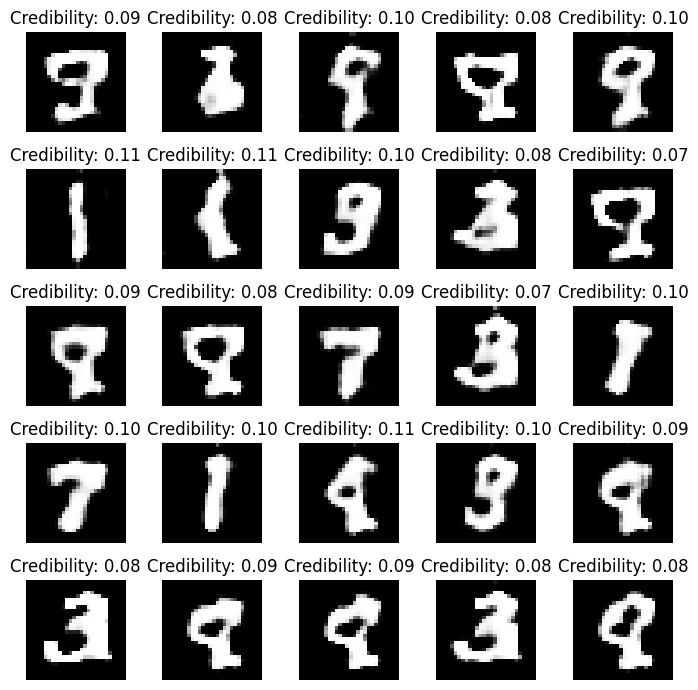

----------------------------------------------------------------------------------------------------
Epoch 8/10


100%|██████████| 438/438 [00:13<00:00, 31.71it/s]


Training Discriminator loss : 0.3481728078023484 | Training Generator loss : 1.572163413157559


100%|██████████| 55/55 [00:00<00:00, 58.37it/s]


Valid Discriminator accuracy : 0.501464307308197


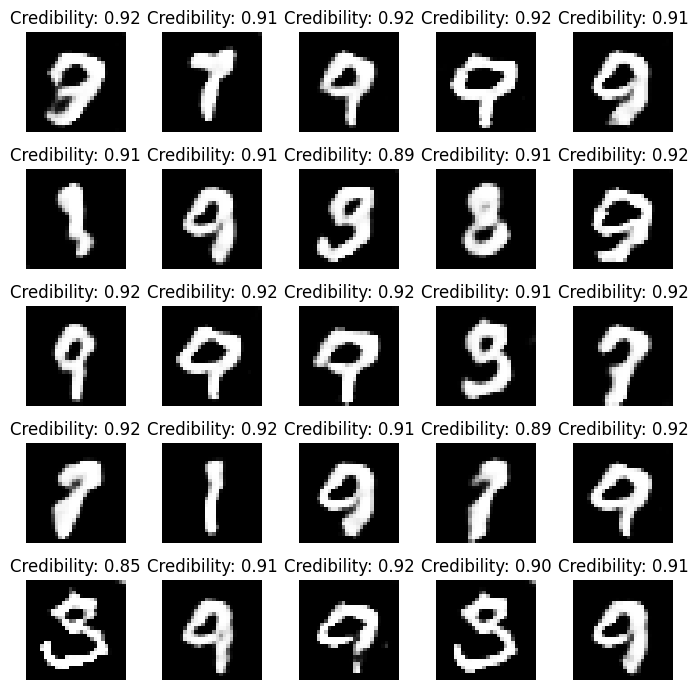

----------------------------------------------------------------------------------------------------
Epoch 9/10


100%|██████████| 438/438 [00:13<00:00, 31.77it/s]


Training Discriminator loss : 0.34928644615221244 | Training Generator loss : 1.780020488764438


100%|██████████| 55/55 [00:00<00:00, 58.71it/s]


Valid Discriminator accuracy : 0.5


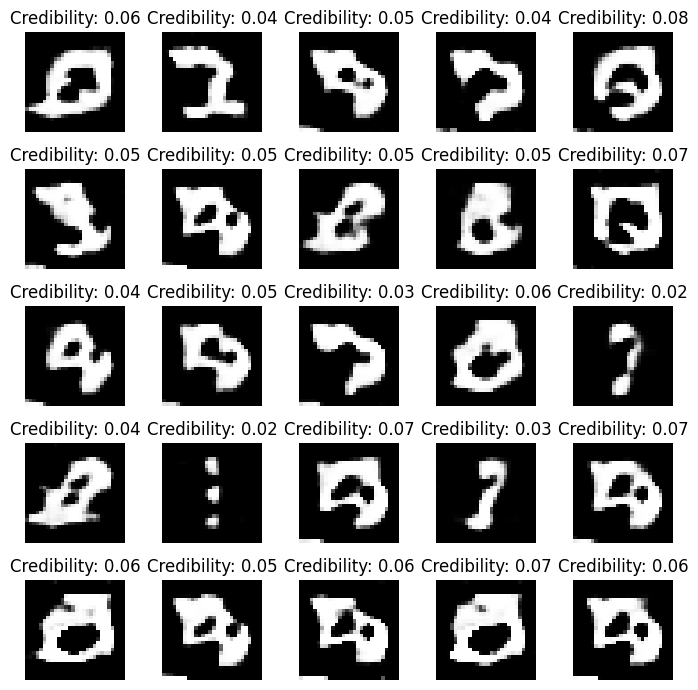

----------------------------------------------------------------------------------------------------
Epoch 10/10


100%|██████████| 438/438 [00:13<00:00, 31.75it/s]


Training Discriminator loss : 0.3394851541002047 | Training Generator loss : 1.3590423008807102


100%|██████████| 55/55 [00:00<00:00, 58.88it/s]


Valid Discriminator accuracy : 0.5708571076393127


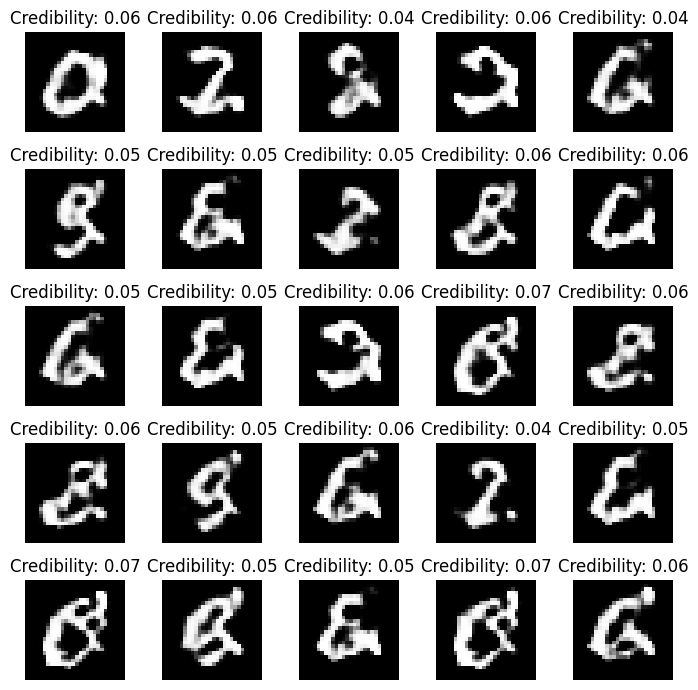

----------------------------------------------------------------------------------------------------


In [10]:
figs = []
for epoch in range(Hyperparams.num_epochs):
    print(f'Epoch {epoch +1}/{Hyperparams.num_epochs}')
    train(train_loader, generator, discriminator, device, g_optimizer, d_optimizer , d_criterion, g_criterion, distribution, epoch)
    accuracy, fig = validate(valid_loader, generator, discriminator, device, distribution, fixed_latent_vectors,epoch)
    figs.append(fig)
    print(f'-' *100)

In [12]:
# I stopped training very early bc I wasn't able to get really good results and spamming Hyperparams search isn't my cup of tea
# I'll improve the training process later maybe once I get more knowledge about GANs in general but i'll try WGANs now 